In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd


# Modeling
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score, f1_score,roc_auc_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# nlp
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer

Before we start the modeling process we will have to prep the data using a train/test split. We will keep the first test set for validation purposes later on and do second train/test split on the train data to use for modeling.

Also, as explained earlier in the exploratory data analysis, we will have to add certain stop words to the stopwords list to reduce the bias of the models.

In [2]:
df = pd.read_json('./data/combined_posts.json')

In [3]:
df.head()

,subreddit,title,news,wordcount,charcount
0,worldnews,COVID-19: India sees record case numbers as mi...,1,14,88
1,TheOnion,Wow: You Can Actually Just Press ‘L3’ To Talk ...,0,22,117
2,TheOnion,Ginsburg Clerks Wheel Filing Cabinets Into Cap...,0,18,114
3,TheOnion,Mental Health Experts Advise On Best Ways To C...,0,15,91
4,worldnews,Iran produces first batch of 60% enriched uranium,1,8,49


In [4]:
#create list 
new_stop_words = ['onion','topical','ep','ho']

In [5]:
#create list from nltk stopword english
stopwords = stopwords.words('english')

In [6]:
#add new stop words to list
stopwords.extend(new_stop_words)

## Defining functions for scores

In [7]:
def print_gs_scores(model, X_train,X_test,y_train,y_test):
    model_scores = [model.best_score_,model.score(X_train,y_train),model.score(X_test,y_test)]
    
    print(f'Best Model Score: {round((model.best_score_),4)}')
    print(f'Training Score: {round(model.score(X_train,y_train),4)}')
    print(f'Testing Score: {round(model.score(X_test,y_test),4)}')
    return model_scores

In [8]:
def print_acc_scores(y_test,preds):
    #create confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()
    #define confusion matrix metrics
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    # f1score = 2 * (precision*sensitivity) / (precision + sensitivity)
    f1score = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)
    acc_scores =[tn,fp,fn,tp, accuracy,sensitivity,specificity,precision,f1score,roc_auc]
    
    #Print scores
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print('-----------------------')
    print('Accuracy:',round(accuracy,3))
    print('Sensitivity:',round(sensitivity,3))
    print('Specificity:',round(specificity,3))
    print('Precision:',round(precision,3))
    print('')
    print(f'F1 score: {round(f1score, 4)}')
    print(f'ROC AUC score: {round(roc_auc, 4)}')
    
    
    return acc_scores

In [9]:
scores_df = pd.DataFrame(index =['BestModelScore','TrainScore','TestScore','TrueNeg','FalsePos','FalseNeg',
                                'TruePos','Accuracy','Sensitivity','Specificity','Precision','F1','ROCAUC'])

I plan on using CountVectorizer and TfidfVectorizer to transform my data. Once that data is transformed I will be fitting it on a logistic regression model, a naive bayes model, and a random forest model. I will also be using gridsearch with a range of hyperparameters to find the best parameters needed to return favorable results.

The best model will then be picked based on the best scores for specificity and sensitivity. By optimizing for both we are minimizing false positives and false negatives. However, minimizing false positives is favorable as we would want to minimize satire being mistaken as news over news being mistaken as satire.

### Data Set 1 :Create Feature Matrix and Target

In [10]:
X = df[['title']]
y = df['news']

### Data Set 2: Create Feature Matrix and Target Including Word/Char count

In [11]:
X2 = df[['title','wordcount','charcount']]
y2 = df['news']

### Preprocessors using ColumnTransformer 

Since we have a mix of categorical and numeric features that we want to transform we will use ColumnTransformer to do the preprocessing before inserting it into the pipeline to do the transformations

In [12]:
cvec = CountVectorizer(stop_words = stopwords)
tvec = TfidfVectorizer(stop_words = stopwords)
log = LogisticRegression()
ss = StandardScaler()

In [13]:
#Set up preprocessor to transform data set 1 using Column Transformer/CountVectorizer
preprocessor = ColumnTransformer(
    transformers =[
        ('cvec',cvec,'title')
    ])

In [14]:
tvec_preprocessor = ColumnTransformer(
    transformers =[
        ('tvec',tvec,'title')
    ])

In [15]:
#Set up preprocessor for dataset 2 using Column Transformer/CountVectorizer/StandardScaler
preprocessor2 = ColumnTransformer(
    transformers =[
        ('ss',ss,['wordcount','charcount']),
        ('cvec',cvec,'title')])

In [16]:
#Set up preprocessor for dataset 2 using Column Transformer/CountVectorizer/StandardScaler
tvec_preprocessor2 = ColumnTransformer(
    transformers =[
        ('ss',ss,['wordcount','charcount']),
        ('tvec',tvec,'title')])

In [17]:
#pipeline for dataset 1 grid search
log_pipe = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('log', LogisticRegression())
])

In [18]:
#pipeline for dataset 1 grid search
tvec_log_pipe = Pipeline(steps =[
    ('preprocessor', tvec_preprocessor),
    ('log', LogisticRegression())
])

In [19]:
#Set up Logistic Regression transformer pipeline for dataset2
log_pipe2 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('classifier', LogisticRegression())])

In [20]:
#Set up Logistic Regression transformer pipeline for dataset2
tvec_log_pipe2 = Pipeline(steps=[('preprocessor', tvec_preprocessor2),
                      ('classifier', LogisticRegression())])

### Split data into train/test data set

In [21]:
#split data into train and test data set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2, random_state = 42,stratify = y)
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size = .2, random_state = 42,stratify = y2)

### Define Baseline Score for Models

In [22]:
print('baseline score:' ,y_test.mean())

baseline score: 0.4868995633187773


In [23]:
set_config(display='diagram')

### Grid Parameters

In [24]:
#set up grid parameters
standard ={
    'preprocessor__cvec__max_features':[800],
    'preprocessor__cvec__ngram_range':[(1,1)],
    'preprocessor__cvec__max_df':[.95],
    'preprocessor__cvec__min_df':[2]
    
}
tvec_standard ={
    'preprocessor__tvec__max_features':[800],
    'preprocessor__tvec__ngram_range':[(1,1)],
    'preprocessor__tvec__max_df':[.95],
    'preprocessor__tvec__min_df':[2]
    
}
param_grid = {
    'preprocessor__cvec__max_features':[600,800,1000,1200],
    'preprocessor__cvec__ngram_range':[(1,1),(2,2)],
    'preprocessor__cvec__max_df':[.9,.95],
    'preprocessor__cvec__min_df':[2,3,4]
    
}
tvec_param_grid = {
    'preprocessor__tvec__max_features':[600,800,1000,1200],
    'preprocessor__tvec__ngram_range':[(1,1),(2,2)],
    'preprocessor__tvec__max_df':[.9,.95],
    'preprocessor__tvec__min_df':[2,3,4]
    
}

### 1.1 Data Set 1 Standard Logistic Regression CountVectorizer

In [25]:
log = GridSearchCV(log_pipe, param_grid = standard, cv =10)

In [26]:
log.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cvec',
                                                                         CountVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('log', LogisticRegression())]),
             param_grid={'preprocessor__cvec__max_df': [0.95],
                         'preprocessor__cvec__max_features': [800],
                         'preprocessor__cvec__min_df': [2],
                         'preprocessor__cvec__ngram_range': [(1, 1)]})

In [27]:
print(f'Cross Validation Score: {cross_val_score(log, X_train,y_train, cv =5).mean()}')

Cross Validation Score: 0.871930982041017


### 1.1 Data Set 1 Standard Logistic Regression Model Score

In [28]:
log_score = print_gs_scores(log,X_train,X_test,y_train,y_test)

Best Model Score: 0.8722
Training Score: 0.9306
Testing Score: 0.8493


In [29]:
log_preds = log.predict(X_test)

### 1.1 Data Set 1 Standard Logistic Regression Model Accuracy Scores

True Negatives: 419
False Positives: 51
False Negatives: 87
True Positives: 359
-----------------------
Accuracy: 0.849
Sensitivity: 0.805
Specificity: 0.891
Precision: 0.876

F1 score: 0.8388
ROC AUC score: 0.8482


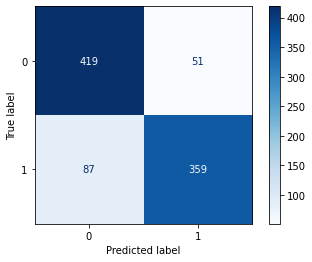

In [30]:
log_acc_scores = print_acc_scores(y_test,log_preds)
#visualize confusion matrix
plot_confusion_matrix(log,X_test,y_test, cmap = 'Blues', values_format ='d')

In [31]:
#add accuracy scores to model scores
log_score.extend(log_acc_scores)
#create column for log model scores
scores_df['log'] = log_score

### 1.2 Data Set 2 Standard Logistic Regresison Model CountVectorizer

In [32]:
log2 = GridSearchCV(log_pipe2, param_grid = standard, cv =10)

In [33]:
log2.fit(X2_train,y2_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['wordcount',
                                                                          'charcount']),
                                                                        ('cvec',
                                                                         CountVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'preprocessor__c

In [34]:
print(f'Cross Validation Score: {cross_val_score(log2, X2_train,y2_train, cv =5).mean()}')

Cross Validation Score: 0.8708406950998591


### 1.2 Data Set 2 Standard Logistic Regression Model Score

In [35]:
log_score2 = print_gs_scores(log2,X2_train,X2_test,y2_train,y2_test)

Best Model Score: 0.8708
Training Score: 0.9295
Testing Score: 0.8559


In [36]:
log_preds2 = log2.predict(X2_test)

### 1.2 Data Set 2 Standard Logistic Regression Model Accuracy Scores

True Negatives: 420
False Positives: 50
False Negatives: 82
True Positives: 364
-----------------------
Accuracy: 0.856
Sensitivity: 0.816
Specificity: 0.894
Precision: 0.879

F1 score: 0.8465
ROC AUC score: 0.8549


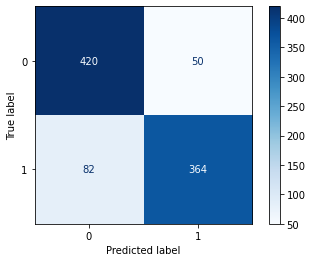

In [37]:
log_acc_score = print_acc_scores(y_test,log_preds2)
#visualize confusion matrix
plot_confusion_matrix(log2,X2_test,y2_test, cmap = 'Blues', values_format ='d')

In [38]:
log_score2.extend(log_acc_score)

In [39]:
scores_df['log2'] = log_score2

The model scores do not differ much from each other. The Logistic Regression model from data set 1 has a a few more false positives than data set 2. Thus, between the two models model 1.2 is slightly better in terms of specificity, the difference between the train and test score is also smaller for model 1.2

### 1.3 Data Set 1 Logistic Regression Model Grid Search CountVectorizer

In [40]:
#instantiate log grid search
log_gs = GridSearchCV(log_pipe, param_grid = param_grid, cv =10)

In [41]:
#Fit gridsearch to training data
log_gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cvec',
                                                                         CountVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('log', LogisticRegression())]),
             param_grid={'preprocessor__cvec__max_df': [0.9, 0.95],
                         'preprocessor__cvec__max_features': [600, 800, 1000,
                                                              1200],
                         'preprocessor__cvec__min_df': [2, 3, 4],
                         'preprocessor__cvec__ngram_range': [(1, 1), (2, 2)]})

In [42]:
#Return Best parameters
log_gs.best_params_

{'preprocessor__cvec__max_df': 0.9,
 'preprocessor__cvec__max_features': 1200,
 'preprocessor__cvec__min_df': 3,
 'preprocessor__cvec__ngram_range': (1, 1)}

### 1.3 Data Set 1 Logistic Regression Model Grid Search Scores

In [43]:
log_gs_score = print_gs_scores(log_gs,X_train,X_test,y_train,y_test)

Best Model Score: 0.8782
Training Score: 0.9525
Testing Score: 0.8624


In [44]:
log_gs_preds = log_gs.predict(X_test)

### 1.3 Data Set 1 Logistic Regression Model Grid Search Accuracy Scores

True Negatives: 423
False Positives: 47
False Negatives: 79
True Positives: 367
-----------------------
Accuracy: 0.862
Sensitivity: 0.823
Specificity: 0.9
Precision: 0.886

F1 score: 0.8535
ROC AUC score: 0.8614


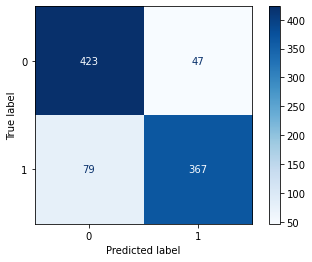

In [45]:
#Print Accuracy Scores for log grid search
log_gs_acc_score = print_acc_scores(y_test,log_gs_preds)
#visualize confusion matrix
plot_confusion_matrix(log_gs,X_test,y_test, cmap = 'Blues', values_format ='d')

In [46]:
#extend scores list
log_gs_score.extend(log_gs_acc_score)
#add score as new column to scores_df
scores_df['log_gs'] = log_gs_score

### 1.4 Data Set 2 Logistic Regression Model Grid Search Scores CountVectorizer

In [47]:
#Instantiate Gridsearch for Logistic Regression Data Set 2
log_gs2 = GridSearchCV(log_pipe2, param_grid = param_grid, cv =10)

In [48]:
#Fit Gridsearch for data set 2 to training data
log_gs2.fit(X2_train,y2_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['wordcount',
                                                                          'charcount']),
                                                                        ('cvec',
                                                                         CountVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'preprocessor__c

In [49]:
#Return Best Params
log_gs2.best_params_

{'preprocessor__cvec__max_df': 0.9,
 'preprocessor__cvec__max_features': 1200,
 'preprocessor__cvec__min_df': 4,
 'preprocessor__cvec__ngram_range': (1, 1)}

### 1.4 Data 2 Logistic Regression Model Grid Search 2 Scores

In [50]:
log_gs_score2 = print_gs_scores(log_gs2,X2_train,X2_test,y2_train,y2_test)

Best Model Score: 0.8777
Training Score: 0.9511
Testing Score: 0.8624


In [51]:
#Get predictions
log_gs_preds2 = log_gs2.predict(X2_test)

### 1.4 Data 2 Logistic Regression Model Grid Search 2 Accuracy Scores

True Negatives: 421
False Positives: 49
False Negatives: 77
True Positives: 369
-----------------------
Accuracy: 0.862
Sensitivity: 0.827
Specificity: 0.896
Precision: 0.883

F1 score: 0.8542
ROC AUC score: 0.8615


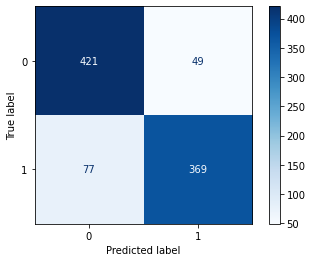

In [52]:
#Print Accuracy scores
log_gs_acc_score2 = print_acc_scores(y2_test,log_gs_preds2)
#visualize confusion matrix
plot_confusion_matrix(log_gs2,X2_test,y2_test, cmap = 'Blues', values_format ='d')

In [53]:
log_gs_score2.extend(log_gs_acc_score2)

In [54]:
scores_df['log_gs2'] = log_gs_score2

From this grid search logistic regression model it can be seen that as you increase the number of features the model score increases. However, increasing the max_features by too much can cause overfitting. It can also be seen that by including word and character count as features in our model our specifity score is slightly slower here for model 1.4. This is most likely caused by the change in parameters. So there is no strong evidence that including character and word count has a strong effect on specificity and sensitivity.

### 1.5 Data 1 Standard Logistic Regression Model TfidfVectorizer

In [55]:
tvec_log = GridSearchCV(tvec_log_pipe, param_grid = tvec_standard, cv =10)

In [56]:
tvec_log.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tvec',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('log', LogisticRegression())]),
             param_grid={'preprocessor__tvec__max_df': [0.95],
                         'preprocessor__tvec__max_features': [800],
                         'preprocessor__tvec__min_df': [2],
                         'preprocessor__tvec__ngram_range': [(1, 1)]})

In [57]:
print(f'Cross Validation Score: {cross_val_score(tvec_log, X_train,y_train, cv =5).mean()}')

Cross Validation Score: 0.8667419616964492


### 1.5 Data Set 1 Standard Logistic Regression Model Score

In [58]:
#Print Scores
tvec_log_score = print_gs_scores(tvec_log,X_train,X_test,y_train,y_test)

Best Model Score: 0.8632
Training Score: 0.9159
Testing Score: 0.8461


In [59]:
#Calculate Preds
tvec_log_preds = tvec_log.predict(X_test)

### 1.5 Data Set 1 Standard Logistic Regression Model Accuracy Scores

True Negatives: 413
False Positives: 57
False Negatives: 84
True Positives: 362
-----------------------
Accuracy: 0.846
Sensitivity: 0.812
Specificity: 0.879
Precision: 0.864

F1 score: 0.837
ROC AUC score: 0.8452


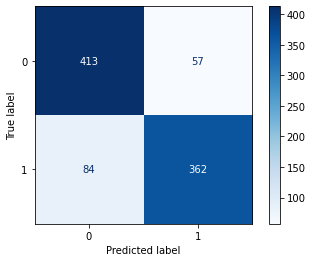

In [60]:
#Print Accuracy Scores
tvec_log_acc_score = print_acc_scores(y_test,tvec_log_preds)
#visualize confusion matrix
plot_confusion_matrix(tvec_log,X_test,y_test, cmap = 'Blues', values_format ='d')

In [61]:
#add accuracy scores to scores list
tvec_log_score.extend(tvec_log_acc_score)

In [62]:
#add scores to dataframe
scores_df['tvec_log'] = tvec_log_score

### 1.6 Data 2 Standard Logistic Regression Model TfidfVectorizer

In [63]:
tvec_log2 = GridSearchCV(tvec_log_pipe2, param_grid = tvec_standard, cv =10)

In [64]:
tvec_log2.fit(X2_train,y2_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['wordcount',
                                                                          'charcount']),
                                                                        ('tvec',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'preprocessor__t

In [65]:
print(f'Cross Validation Score: {cross_val_score(tvec_log2, X2_train,y2_train, cv =5).mean()}')

Cross Validation Score: 0.8656501837646025


### 1.6 Data Set 2 Standard Logistic Regression Model Score

In [66]:
#Print Scores
tvec_log_score2 = print_gs_scores(tvec_log2,X2_train,X2_test,y2_train,y2_test)

Best Model Score: 0.8624
Training Score: 0.9156
Testing Score: 0.8461


In [67]:
#Calculate Preds
tvec_log_preds2 = tvec_log2.predict(X2_test)

### 1.6 Data Set 2 Standard Logistic Regression Model Accuracy Scores

True Negatives: 414
False Positives: 56
False Negatives: 85
True Positives: 361
-----------------------
Accuracy: 0.846
Sensitivity: 0.809
Specificity: 0.881
Precision: 0.866

F1 score: 0.8366
ROC AUC score: 0.8451


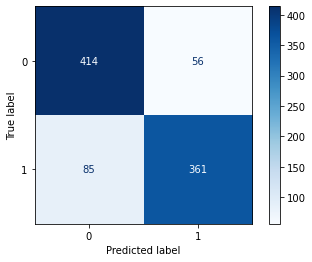

In [68]:
#Print Accuracy Scores
tvec_log_acc_score2 = print_acc_scores(y2_test,tvec_log_preds2)
#visualize confusion matrix
plot_confusion_matrix(tvec_log2,X2_test,y2_test, cmap = 'Blues', values_format ='d')

In [69]:
#add accuracy scores to scores list
tvec_log_score2.extend(tvec_log_acc_score2)

In [70]:
#add scores to dataframe
scores_df['tvec_log2'] = tvec_log_score2

Transforming the data with tfifdvectorizer lowers both our specificity and sensitivity score which is evident in the increase in both false positive and negatives. Thus, this model is probably not favorable. Again there is no evidence that character and word count have an effect on the sensitivity and specificity scores

### 1.7 Data Set 1 Logistic Regression Model Grid Search TfidfVectorizer

In [71]:
#instantiate log grid search
tvec_log_gs = GridSearchCV(tvec_log_pipe, param_grid = tvec_param_grid, cv =10)

In [72]:
#Fit gridsearch to training data
tvec_log_gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tvec',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('log', LogisticRegression())]),
             param_grid={'preprocessor__tvec__max_df': [0.9, 0.95],
                         'preprocessor__tvec__max_features': [600, 800, 1000,
                                                              1200],
                         'preprocessor__tvec__min_df': [2, 3, 4],
                         'preprocessor__tvec__ngram_range': [(1, 1), (2, 2)]})

In [73]:
#Return Best parameters
tvec_log_gs.best_params_

{'preprocessor__tvec__max_df': 0.9,
 'preprocessor__tvec__max_features': 1200,
 'preprocessor__tvec__min_df': 3,
 'preprocessor__tvec__ngram_range': (1, 1)}

### 1.7 Data Set 1 Logistic Regression Model Grid Search Scores TfidfVectorizer

In [74]:
#print scores
tvec_log_gs_score = print_gs_scores(tvec_log_gs,X_train,X_test,y_train,y_test)

Best Model Score: 0.8777
Training Score: 0.9328
Testing Score: 0.8603


In [75]:
#calculate preds
tvec_log_gs_preds = tvec_log_gs.predict(X_test)

### 1.7 Data Set 1 Logistic Regression Model Grid Search Accuracy Scores TfidfVectorizer

True Negatives: 420
False Positives: 50
False Negatives: 78
True Positives: 368
-----------------------
Accuracy: 0.86
Sensitivity: 0.825
Specificity: 0.894
Precision: 0.88

F1 score: 0.8519
ROC AUC score: 0.8594


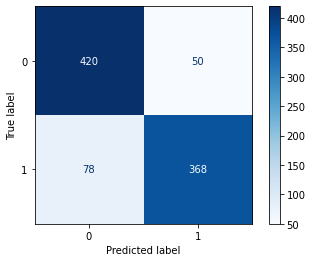

In [76]:
#Print Accuracy Scores for log grid search
tvec_log_gs_acc_score = print_acc_scores(y_test,tvec_log_gs_preds)
#visualize confusion matrix
plot_confusion_matrix(tvec_log_gs,X_test,y_test, cmap = 'Blues', values_format ='d')

In [77]:
#add accuracy scores to scores list
tvec_log_gs_score.extend(tvec_log_gs_acc_score)

In [78]:
#add scores to data frame
scores_df['tvec_log_gs'] = tvec_log_gs_score

### 1.8 Data Set 2 Logistic Regression Model Grid Search TfidfVectorizer

In [79]:
#instantiate log grid search
tvec_log_gs2 = GridSearchCV(tvec_log_pipe2, param_grid = tvec_param_grid, cv =10)

In [80]:
#Fit gridsearch to training data
tvec_log_gs2.fit(X2_train,y2_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['wordcount',
                                                                          'charcount']),
                                                                        ('tvec',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'preprocessor__t

In [81]:
#Return Best parameters
tvec_log_gs2.best_params_

{'preprocessor__tvec__max_df': 0.9,
 'preprocessor__tvec__max_features': 1000,
 'preprocessor__tvec__min_df': 3,
 'preprocessor__tvec__ngram_range': (1, 1)}

### 1.8 Data Set 2 Logistic Regression Model Grid Search Scores TfidfVectorizer

In [82]:
#print scores
tvec_log_gs_score2 = print_gs_scores(tvec_log_gs2,X2_train,X2_test,y2_train,y2_test)

Best Model Score: 0.8727
Training Score: 0.9246
Testing Score: 0.8472


In [83]:
#calculate preds
tvec_log_gs_preds2 = tvec_log_gs.predict(X2_test)

/Users/allenlim/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


### 1.8 Data Set 2 Logistic Regression Model Grid Search Accuracy Scores TfidfVectorizer

True Negatives: 420
False Positives: 50
False Negatives: 78
True Positives: 368
-----------------------
Accuracy: 0.86
Sensitivity: 0.825
Specificity: 0.894
Precision: 0.88

F1 score: 0.8519
ROC AUC score: 0.8594


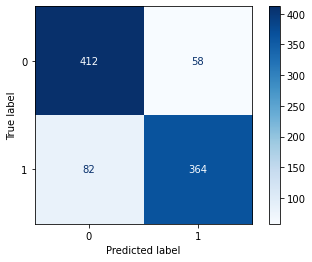

In [84]:
#Print Accuracy Scores for log grid search
tvec_log_gs_acc_score2 = print_acc_scores(y_test,tvec_log_gs_preds2)
#visualize confusion matrix
plot_confusion_matrix(tvec_log_gs2,X2_test,y2_test, cmap = 'Blues', values_format ='d')

In [85]:
#add accuracy scores to scores list
tvec_log_gs_score2.extend(tvec_log_gs_acc_score2)

In [86]:
#add scores to data frame
scores_df['tvec_log_gs2'] = tvec_log_gs_score2

Our Grid search model for logistic regression where tfidvectorizer is used as a transformer returns a lower test score than if CountVectorizer is used. Also using GridSearch on tfidvectorizer returns a higher training score but lower test score. The number of false negatives in the gridsearch version also increase. Thus, this model may not be the most favorable. Next we shall use the Naive Bayes model and examine the results

## Naive Bayes Model

## Setting Up Pipelines for Naive Bayes Model

In [87]:
#tvec naive bayes pipeline fo gridsearch
tvec_nb_pipe_grid = Pipeline(steps =[
    ('preprocessor', tvec_preprocessor),
    ('nb', MultinomialNB())
])

In [88]:
#naive bayes pipeline for grid search
nb_pipe_grid = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('nb', MultinomialNB())
])

In [89]:
#tvec NB pipeline for dataset
tvec_nb_pipe = Pipeline(steps =[
    ('preprocessor', tvec_preprocessor),
    ('nb', MultinomialNB())
])

In [90]:
#NB pipeline for dataset
nb_pipe = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('nb', MultinomialNB())
])

### 2.1 Standard Naive Bayes Model CountVectorizer

In [91]:
#instantiate model
nb = GridSearchCV(nb_pipe, param_grid = standard, cv =10)

In [92]:
#fit model
nb.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cvec',
                                                                         CountVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('nb', MultinomialNB())]),
             param_grid={'preprocessor__cvec__max_df': [0.95],
                         'preprocessor__cvec__max_features': [800],
                         'preprocessor__cvec__min_df': [2],
                         'preprocessor__cvec__ngram_range': [(1, 1)]})

In [93]:
#print cv score
print(f'Cross Validation Score: {cross_val_score(nb, X_train,y_train, cv =5).mean()}')

Cross Validation Score: 0.865379941702264


### 2.1 Standard Naive Bayes Model Score CountVectorizer

In [94]:
#print scores
nb_scores = print_gs_scores(nb,X_train,X_test,y_train,y_test)

Best Model Score: 0.8654
Training Score: 0.8965
Testing Score: 0.8428


### 2.1 Standard Naive Bayes Model Accuracy Score CountVectorizer

In [95]:
#calculate preds
nb_preds = nb.predict(X_test)

True Negatives: 395
False Positives: 75
False Negatives: 69
True Positives: 377
-----------------------
Accuracy: 0.843
Sensitivity: 0.845
Specificity: 0.84
Precision: 0.834

F1 score: 0.8396
ROC AUC score: 0.8429


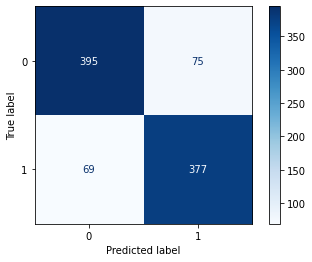

In [96]:
#print accuracy scores
nb_acc_scores = print_acc_scores(y_test,nb_preds)
#visualize confusion matrix
plot_confusion_matrix(nb,X_test,y_test, cmap = 'Blues', values_format ='d')

In [97]:
#add accuracy scores to scores list
nb_scores.extend(nb_acc_scores)

In [98]:
#add scores to dataframe
scores_df['nb'] = nb_scores

### 2.2 Standard Naive Bayes Model Score TfidfVectorizer

In [99]:
#instantiate model
tvec_nb = GridSearchCV(tvec_nb_pipe, param_grid = tvec_standard, cv =10)

In [100]:
#fit model
tvec_nb.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tvec',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('nb', MultinomialNB())]),
             param_grid={'preprocessor__tvec__max_df': [0.95],
                         'preprocessor__tvec__max_features': [800],
                         'preprocessor__tvec__min_df': [2],
                         'preprocessor__tvec__ngram_range': [(1, 1)]})

In [101]:
#calculate cv-score
print(f'Cross Validation Score: {cross_val_score(tvec_nb, X_train,y_train, cv =5).mean()}')

Cross Validation Score: 0.8610105934888438


### 2.2 Standard Naive Bayes Model Accuracy Score TfidfVectorizer

In [102]:
#print scores
tvec_nb_scores = print_gs_scores(tvec_nb,X_train,X_test,y_train,y_test)

Best Model Score: 0.8616
Training Score: 0.8962
Testing Score: 0.8472


In [103]:
#calculate preds
tvec_nb_preds = tvec_nb.predict(X_test)

### 2.2 Standard Naive Bayes Model Scores TfidfVectorizer

True Negatives: 400
False Positives: 70
False Negatives: 70
True Positives: 376
-----------------------
Accuracy: 0.847
Sensitivity: 0.843
Specificity: 0.851
Precision: 0.843

F1 score: 0.843
ROC AUC score: 0.8471


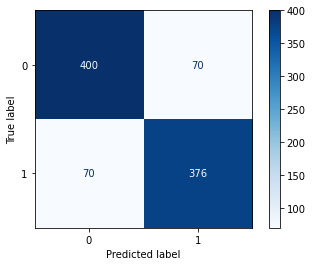

In [104]:
tvec_nb_acc_scores = print_acc_scores(y_test,tvec_nb_preds)
#visualize confusion matrix
plot_confusion_matrix(tvec_nb,X_test,y_test, cmap = 'Blues', values_format ='d')

In [105]:
tvec_nb_scores.extend(tvec_nb_acc_scores)
scores_df['tvec_nb'] = tvec_nb_scores

For our standard naive bayes model, using the CountVectorizer transformation returned better results in terms of specificty and false positives. However, the numnbers are worse compared to the logisitc regression model.

### 2.3 Naive Bayes Model Grid Search Model CountVectorizer

In [106]:
nb_gs = GridSearchCV(nb_pipe_grid, param_grid = param_grid, cv =10)

In [107]:
nb_gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cvec',
                                                                         CountVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('nb', MultinomialNB())]),
             param_grid={'preprocessor__cvec__max_df': [0.9, 0.95],
                         'preprocessor__cvec__max_features': [600, 800, 1000,
                                                              1200],
                         'preprocessor__cvec__min_df': [2, 3, 4],
                         'preprocessor__cvec__ngram_range': [(1, 1), (2, 2)]})

In [108]:
nb_gs.best_params_

{'preprocessor__cvec__max_df': 0.9,
 'preprocessor__cvec__max_features': 1200,
 'preprocessor__cvec__min_df': 2,
 'preprocessor__cvec__ngram_range': (1, 1)}

In [109]:
nb_gs_scores = print_gs_scores(nb_gs,X_train,X_test,y_train,y_test)

Best Model Score: 0.8771
Training Score: 0.9137
Testing Score: 0.8526


In [110]:
nb_gs_preds = nb_gs.predict(X_test)

True Negatives: 398
False Positives: 72
False Negatives: 63
True Positives: 383
-----------------------
Accuracy: 0.853
Sensitivity: 0.859
Specificity: 0.847
Precision: 0.842

F1 score: 0.8502
ROC AUC score: 0.8528


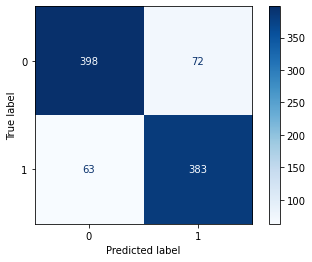

In [111]:
nb_gs_acc_scores = print_acc_scores(y_test,nb_gs_preds)
#visualize confusion matrix
plot_confusion_matrix(nb_gs,X_test,y_test, cmap = 'Blues', values_format ='d')

In [112]:
nb_gs_scores.extend(nb_gs_acc_scores)
scores_df['nb_gs'] = nb_gs_scores

### 2.4 Naive Bayes Model Grid Search Model TfidfVectorizer

In [113]:
tvec_nb_gs = GridSearchCV(tvec_nb_pipe_grid, param_grid = tvec_param_grid, cv =10)

In [114]:
tvec_nb_gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tvec',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('nb', MultinomialNB())]),
             param_grid={'preprocessor__tvec__max_df': [0.9, 0.95],
                         'preprocessor__tvec__max_features': [600, 800, 1000,
                                                              1200],
                         'preprocessor__tvec__min_df': [2, 3, 4],
                         'preprocessor__tvec__ngram_range': [(1, 1), (2, 2)]})

In [115]:
tvec_nb_gs.best_params_

{'preprocessor__tvec__max_df': 0.9,
 'preprocessor__tvec__max_features': 1200,
 'preprocessor__tvec__min_df': 2,
 'preprocessor__tvec__ngram_range': (1, 1)}

In [116]:
tvec_nb_gs_scores = print_gs_scores(tvec_nb_gs,X_train,X_test,y_train,y_test)

Best Model Score: 0.8717
Training Score: 0.9189
Testing Score: 0.8526


In [117]:
tvec_nb_gs_preds = tvec_nb_gs.predict(X_test)

True Negatives: 399
False Positives: 71
False Negatives: 64
True Positives: 382
-----------------------
Accuracy: 0.853
Sensitivity: 0.857
Specificity: 0.849
Precision: 0.843

F1 score: 0.8498
ROC AUC score: 0.8527


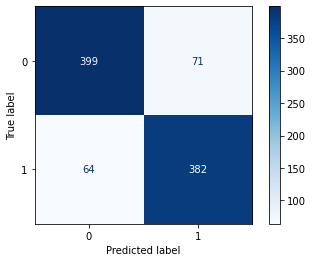

In [118]:
tvec_nb_gs_acc_scores = print_acc_scores(y_test,tvec_nb_gs_preds)
#visualize confusion matrix
plot_confusion_matrix(tvec_nb_gs,X_test,y_test, cmap = 'Blues', values_format ='d')

In [119]:
tvec_nb_gs_scores.extend(tvec_nb_gs_acc_scores)
scores_df['tvec_nb_gs'] = tvec_nb_gs_scores

Our Naive Bayes gridsearch model perform at about the same level in terms of specificity and sensitivity. Using grid search did not improve our model but did improve our training score. However, this is most likely due to the increase in max_features in the transformer which is a sign of overfitting

## Random Forest Model

## Setting Up Pipelines for Random Forest Model

In [120]:
#tvec random forest pipeline for gridsearch
tvec_rf_pipe_grid = Pipeline(steps =[
    ('preprocessor', tvec_preprocessor),
    ('rf', RandomForestClassifier())
])

In [121]:
#cvec random forest pipeline for gridsearch
rf_pipe_grid = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

In [122]:
#tvec random forest pipeline for dataset
tvec_rf_pipe = Pipeline(steps =[
    ('preprocessor', tvec_preprocessor),
    ('rf', RandomForestClassifier())
])

In [123]:
#cvec random forest pipeline for dataset
rf_pipe = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

### Setting Up Random Forest Pipeline Parameters

In [124]:
#cvec random forest parameters
rf_standard ={
    'preprocessor__cvec__max_features':[800],
    'preprocessor__cvec__ngram_range':[(1,1)],
    'preprocessor__cvec__max_df':[.95],
    'preprocessor__cvec__min_df':[2],   
}
#tvec random forest paramters
tvec_rf_standard ={
    'preprocessor__tvec__max_features':[800],
    'preprocessor__tvec__ngram_range':[(1,1)],
    'preprocessor__tvec__max_df':[.95],
    'preprocessor__tvec__min_df':[2],    
}

#cvec random forest parameters for grid search
param_rf_grid = {
    'preprocessor__cvec__max_features':[600,800,1000,1200],
    'preprocessor__cvec__ngram_range':[(1,1),(2,2)],
    'preprocessor__cvec__max_df':[.9,.95],
    'preprocessor__cvec__min_df':[2,3,4],
    'rf__n_estimators':[100,150,200,250],
    'rf__max_depth':[None, 1,2,3,4,5]    
}
#tvec random forest parameters for grid search
tvec_rf_param_grid = {
    'preprocessor__tvec__max_features':[600,800,1000,1200],
    'preprocessor__tvec__ngram_range':[(1,1),(2,2)],
    'preprocessor__tvec__max_df':[.9,.95],
    'preprocessor__tvec__min_df':[2,3,4],
    'rf__n_estimators':[100,150,200,250],
    'rf__max_depth':[None, 1,2,3,4,5]
}

### 3.1 Random Forest Model Count Vectorizer

In [125]:
#instantiate model
rf = GridSearchCV(rf_pipe, param_grid = rf_standard, cv =10)

In [126]:
#fit model
rf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cvec',
                                                                         CountVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'preprocessor__cvec__max_df': [0.95],
                         'preprocessor__cvec__max_features': [800],
                         'preprocessor__cvec__min_df': [2],
                         'preprocessor__cvec__ngram_range': [(1, 1)]})

In [127]:
#print cv score
print(f'Cross Validation Score: {cross_val_score(rf, X_train,y_train, cv =5).mean()}')

Cross Validation Score: 0.8427112920179815


### 3.1 Random Forest Model Score CountVectorizer

In [128]:
#print score
rf_scores = print_gs_scores(rf,X_train,X_test,y_train,y_test)

Best Model Score: 0.8413
Training Score: 0.9902
Testing Score: 0.8221


### 3.1 Random Forest Model Accuracy Score CountVectorizer

In [129]:
#calculate preds
rf_preds = rf.predict(X_test)

True Negatives: 380
False Positives: 90
False Negatives: 73
True Positives: 373
-----------------------
Accuracy: 0.822
Sensitivity: 0.836
Specificity: 0.809
Precision: 0.806

F1 score: 0.8207
ROC AUC score: 0.8224


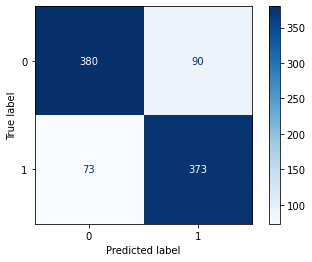

In [130]:
#print accuracy scores
rf_acc_scores = print_acc_scores(y_test,rf_preds)
#visualize confusion matrix
plot_confusion_matrix(rf,X_test,y_test, cmap = 'Blues', values_format ='d')

In [131]:
#add accuracy score to score list
rf_scores.extend(rf_acc_scores)

In [132]:
#add scores to dataframe
scores_df['rf'] = rf_scores

### 3.2 Random Forest Model Count TfidfVectorizer

In [133]:
#instantiate model
tvec_rf = GridSearchCV(tvec_rf_pipe, param_grid = tvec_rf_standard, cv =10)

In [134]:
#fit model
tvec_rf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tvec',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'title')])),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'preprocessor__tvec__max_df': [0.95],
                         'preprocessor__tvec__max_features': [800],
                         'preprocessor__tvec__min_df': [2],
                         'preprocessor__tvec__ngram_range': [(1, 1)]})

In [135]:
print(f'Cross Validation Score: {cross_val_score(tvec_rf, X_train,y_train, cv =5).mean()}')

Cross Validation Score: 0.8544509799536302


### 3.2 Random Forest Model Score TfidfVectorizer

In [136]:
tvec_rf_scores = print_gs_scores(tvec_rf,X_train,X_test,y_train,y_test)

Best Model Score: 0.8569
Training Score: 0.9899
Testing Score: 0.8428


### 3.2 Random Forest Model Accuracy Score TfidfVectorizer

In [137]:
#calculate preds
tvec_rf_preds = tvec_rf.predict(X_test)

True Negatives: 404
False Positives: 66
False Negatives: 78
True Positives: 368
-----------------------
Accuracy: 0.843
Sensitivity: 0.825
Specificity: 0.86
Precision: 0.848

F1 score: 0.8364
ROC AUC score: 0.8423


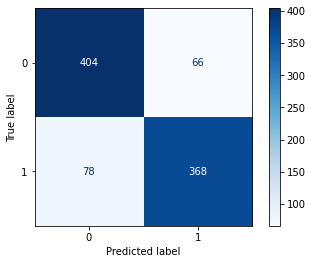

In [138]:
#print accuracy scores
tvec_rf_acc_scores = print_acc_scores(y_test,tvec_rf_preds)
#visualize confusion matrix
plot_confusion_matrix(tvec_rf,X_test,y_test, cmap = 'Blues', values_format ='d')

In [139]:
tvec_rf_scores.extend(tvec_rf_acc_scores)

In [140]:
scores_df['tvec_rf'] = tvec_rf_scores

The random forest models without grid search performed quite poorly compared to the logistic regression model. However random forest using tfidfvectorizer as a transformer does much better in terms of specificity. This is reflected in the score and the false positive values. Furthermore, the difference between the train and test score is too large which is a sign of overfitting. Thus, this model is not favorable when optimizing for specificity. It is quite apparent that random forest model does not return favorable results and will not be used over logistic regression so a grid search model of it will not be performed

In [141]:
#round values in scores data frame
scores_df = scores_df.round(3)

In [142]:
scores_df.to_csv(r'./data/scores.csv')

In [143]:
scores_df

,log,log2,log_gs,log_gs2,tvec_log,tvec_log2,tvec_log_gs,tvec_log_gs2,nb,tvec_nb,nb_gs,tvec_nb_gs,rf,tvec_rf
BestModelScore,0.872,0.871,0.878,0.878,0.863,0.862,0.878,0.873,0.865,0.862,0.877,0.872,0.841,0.857
TrainScore,0.931,0.930,0.952,0.951,0.916,0.916,0.933,0.925,0.897,0.896,0.914,0.919,0.990,0.990
TestScore,0.849,0.856,0.862,0.862,0.846,0.846,0.860,0.847,0.843,0.847,0.853,0.853,0.822,0.843
TrueNeg,419.000,420.000,423.000,421.000,413.000,414.000,420.000,420.000,395.000,400.000,398.000,399.000,380.000,404.000
FalsePos,51.000,50.000,47.000,49.000,57.000,56.000,50.000,50.000,75.000,70.000,72.000,71.000,90.000,66.000
FalseNeg,87.000,82.000,79.000,77.000,84.000,85.000,78.000,78.000,69.000,70.000,63.000,64.000,73.000,78.000
TruePos,359.000,364.000,367.000,369.000,362.000,361.000,368.000,368.000,377.000,376.000,383.000,382.000,373.000,368.000
Accuracy,0.849,0.856,0.862,0.862,0.846,0.846,0.860,0.860,0.843,0.847,0.853,0.853,0.822,0.843
Sensitivity,0.805,0.816,0.823,0.827,0.812,0.809,0.825,0.825,0.845,0.843,0.859,0.857,0.836,0.825
Specificity,0.891,0.894,0.900,0.896,0.879,0.881,0.894,0.894,0.840,0.851,0.847,0.849,0.809,0.860


## Conclusion

The main goal of this project was to build a model that could differentiate the headlines of satirical news and real news. In order to find the best model, it was important to run different version of the model with different transformations and features. Ideally we wanted to optimize for both specificity and sensitity to reduce both of the false positive and negatives. However, since it is more important to reduce the satire that is being mistaken for real news, minimizing false positives was favorable over optimizing for both.

From our models it can be seen that model 1.3 Logistic Regression using grid search and countvectorizer transformer performed the best out of all the model since it minimized fale postitives and maximized specificty as a result. Including character and word count as features in the model did not seem to improve or worsen the models in any way.

Thus we should use a logistic regression model with grid search as our model to classify our titles to our subreddits. There is still a lot of room for improvement though. 

Future recommendations would include collecting more data to have a larger data set to work with, including the contents of the article as features and possibly article length and word count as well. Also collecting more data from other satirical news articles would help improve our model as well. The distribution of the articles in terms of the content was definitely slightly biased since posts from r/worldnews included articles from many different news sources while posts from r/TheOnion were exclusively from the onion.

There definitely is a different kind of danger involved with categorizing news as satire but not to the degree that categorizing satire as news has considering the statistics of how quickly misinformation spreads.